In [2]:
import pandas as pd
import os,re,sarge
import numpy as np
from Bio import SeqIO
from natsort import natsorted
from pybedtools import BedTool
import matplotlib.pyplot as plt
import copy
%matplotlib inline
plt.style.use('ggplot')

In [3]:
ribo_taper_path  = '/data/shangzhong/RibosomeProfiling/Ribotaper'
pasa_path = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie'
picr_rna = pasa_path + '/03_pasa_stringtie_rna.fa'
orf = ribo_taper_path + '/ORFs_max'
orf_fil = ribo_taper_path + '/ORFs_max_filt'
thread = 16
ham_gff = pasa_path + '/03_pasa_stringtie.gff3'

In the RiboTaper result file ORFs_max_filt, the CDS start and stop position is represented using start position of P site, in the downstream analysis it would be easier to change it to the typical position as gff file.

In [4]:
def get_rna_coding_regions(rna_fa):
    '''this function gets the start and end positions of CDS relative to rna sequence in the form
    {rna:[cds_s,cds_e]}'''
    rna_dic = SeqIO.index(picr_rna,'fasta')
    cds_s_e_dic = {}
    for r in rna_dic:
        desp = rna_dic[r].description
        try:
            pos = re.search('(?<=CDS=).+?(?=$)',desp).group(0).split('-')
            pos = [int(p) for p in pos]
            pos[0] -= 1
#             cds_s_e_dic['-'.join(r.split('_'))] = pos
            cds_s_e_dic[r] = pos
        except:
            pass
    return cds_s_e_dic

In [5]:
# change anno start and end position to gff format, 1 based
cds_s_e_dic = get_rna_coding_regions(picr_rna)
orf_fil_df = pd.read_csv(orf_fil,sep='\t',header=0)
orf_fil_df['transcript_id'] = orf_fil_df['transcript_id'].map(lambda x: '_'.join(x.split('-')))
orf_fil_df['annotated_start'] = orf_fil_df['transcript_id'].map(lambda x: 
                        int(cds_s_e_dic[x][0]) if x in cds_s_e_dic else None)
orf_fil_df['annotated_stop'] = orf_fil_df['transcript_id'].map(lambda x: 
                        int(cds_s_e_dic[x][1]) if x in cds_s_e_dic else None)
orf_fil_df['stop_pos'] += 2
orf_fil_df['start_pos'] -= 1

Ribotaper doesn't tell which isoforms the reads come from, it reports all the isofroms. eg:

...........AUG..|..|----intron--..|..|..|---intron---|..|..|..Stop

...........AUG..|..|------------intron---------------|..|..|..Stop
Both ORFs may be reported, but it does not necessarily mean that both actually exist.
So let's first check how many rnas in annotation doesn't have proteins, but their isoforms encode proteins.

In [6]:
def ncrna_gene_has_pr(gff):
    '''this function finds noncoding transcripts whose isoforms have proteins 
    these transcripts are probably not noncoding rnas.'''
    gff_df = pd.read_csv(ham_gff,sep='\t',header=None,comment='#')
    rna_df = gff_df[gff_df[2].values == 'mRNA']
    rna_df = rna_df.reset_index(drop=True)
    rna_df['rnaid'] = rna_df[8].map(lambda x:re.search('(?<=ID=).+?(?=;)',x).group(0))
#     rna_df['rnaid'] = rna_df['rnaid'].map(lambda x: '-'.join(x.split('_')))
    rna_df['geneid']= rna_df[8].map(lambda x:re.search('(?<=gene_id=).+?(?=;)',x).group(0))
    rna_gid_dic = rna_df.set_index('rnaid')['geneid']

    cds_df = gff_df[gff_df[2].values=='CDS']
    cds_df = cds_df.reset_index(drop=True)
    cds_df['rnaid'] = cds_df[8].map(lambda x:re.search('(?<=Parent=).+?(?=;)',x).group(0))
#     cds_df['rnaid'] = cds_df['rnaid'].map(lambda x: '-'.join(x.split('_')))
    cds_df['geneid']=cds_df[8].map(lambda x:re.search('(?<=gene_id=).+?(?=;)',x).group(0))
    coding_rnas = cds_df['rnaid'].unique().tolist()
    id_df = cds_df[['rnaid','geneid']].drop_duplicates()
    gid_crna_dic = {k:list(v) for k,v in id_df.groupby('geneid')['rnaid']}
    ncrna = list(set(rna_gid_dic.keys())-set(coding_rnas))
    ncrna_crna_dic = {}
    for rna in ncrna:
        try:
            gid = rna_gid_dic[rna]
            rnas = gid_crna_dic[gid]
            ncrna_crna_dic[rna] = [gid,rnas]
        except:
            pass
    return ncrna_crna_dic

ncrna_crna_dic = ncrna_gene_has_pr(ham_gff)
ncrna_crnas = ncrna_crna_dic.keys()
print 'there are',len(ncrna_crnas),'rnas that do not have proteins, but their isoforms have proteins,'\
    'which indicates they may not be lncRNA'

there are 10 rnas that do not have proteins, but their isoforms have proteins,which indicates they may not be lncRNA


For some transcripts, ribotaper reports more than one protein. We split rnas with/without duplicated proteins and analyze them separtely. Each of them would have 3 categories when comparing with annotation: 
1. Annotation doesn't have protein.
2. start in the same frame, which means the end is the same.
3. start in the different frame, which means the end is not the same.

### Analyze transcripts with unique proteins first

In [7]:
# get duplicated rnas
dup_rnas = orf_fil_df[orf_fil_df['transcript_id'].duplicated()]['transcript_id'].unique().tolist()
uni_rnas = list(set(orf_fil_df['transcript_id'].unique().tolist())-set(dup_rnas))
uni_df = orf_fil_df[~orf_fil_df['transcript_id'].isin(dup_rnas)]
uni_df = uni_df.reset_index(drop=True)
dup_df = orf_fil_df[orf_fil_df['transcript_id'].isin(dup_rnas)]
dup_df = dup_df.reset_index(drop=True)

In [8]:
def get_rnas_in_diff_categories(uni_df):
    '''this function extract transcripts that have same proteins, have new proteins
    have different proteins in same frame, have different proteins in diff frame'''
    uni_same_rnas = uni_df.query('(start_pos==annotated_start) and (stop_pos==annotated_stop)')\
                    ['transcript_id'].unique().tolist()
    uni_no_rnas = uni_df[uni_df['annotated_start'].isnull()]['transcript_id'].unique().tolist()
    uni_diff_df = uni_df[~uni_df['transcript_id'].isin(uni_same_rnas+uni_no_rnas)]
    uni_diff_df = uni_diff_df.reset_index(drop=True)
    # change to integer
    uni_diff_df['annotated_start'] = uni_diff_df['annotated_start'].astype('int')
    uni_diff_df['annotated_stop'] = uni_diff_df['annotated_stop'].astype('int')
    # split same frame and different frame
    uni_diff_sf_rnas_df = uni_diff_df.query('(start_pos-annotated_start)%3==0')
    uni_diff_sf_rnas = uni_diff_sf_rnas_df['transcript_id'].unique().tolist()
    uni_diff_df_rnas_df = uni_diff_df.query('(start_pos-annotated_start)%3!=0')
    uni_diff_df_rnas = uni_diff_df_rnas_df['transcript_id'].unique().tolist()
    return uni_same_rnas, uni_no_rnas, uni_diff_sf_rnas, uni_diff_df_rnas, uni_diff_sf_rnas_df,\
        uni_diff_df_rnas_df

uni_rna_types = get_rnas_in_diff_categories(uni_df)
print 'In',len(uni_rnas),'transcripts with unique proteins, there are',len(uni_rna_types[0]),'have same '\
'proteins,',len(uni_rna_types[1]),'have new proteins,',len(uni_rna_types[2]),'have diff proteins '\
'in the same frame,',len(uni_rna_types[3]),'have diff proteins in diff frame'
uni_fil_no_rnas = list(set(uni_rna_types[1])-set(ncrna_crnas))
print 'After filterring out non coding rnas whose isoforms encode rnas, there are',\
len(uni_fil_no_rnas),'left to be further analyzed'
print 'there are',len(dup_rnas),'transcripts have duplicated proteins'

In 24709 transcripts with unique proteins, there are 13666 have same proteins, 1318 have new proteins, 8775 have diff proteins in the same frame, 950 have diff proteins in diff frame
After filterring out non coding rnas whose isoforms encode rnas, there are 1318 left to be further analyzed
there are 3991 transcripts have duplicated proteins


We are only interested in the proteins that are different from annotation.
1. For transcripts with new proteins, we keep the ones whose isoforms don't encode proteins.
2. For transcripts with diff proteins, we check how many of them are extended or shrinked.
First, let's see for different protiens in the same frame, how many proteins are extended or shriked compared to annotation

there are 305 extend rnas
there are 8187 shrink rans
there are 189 utr5 rnas
there are 93 utr3 rnas


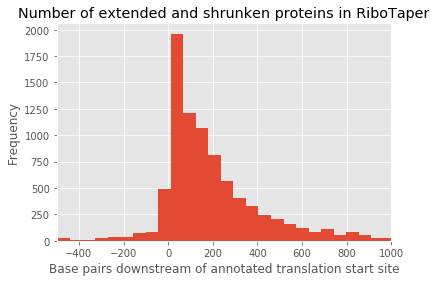

In [46]:
plt.rcParams["figure.figsize"] = (6,4)
uni_diff_sf_rna_df = uni_rna_types[4]
uni_diff_sf_rna_df['dist']=uni_diff_sf_rna_df['annotated_start']-uni_diff_sf_rna_df['start_pos']
extend_rnas = uni_diff_sf_rna_df.query('(dist>0) & (stop_pos>annotated_start)')['transcript_id'].unique().tolist()
shrink_rnas = uni_diff_sf_rna_df.query('(dist<0) & (start_pos<annotated_stop)')['transcript_id'].unique().tolist()
uni_sf_utr5_rnas = uni_diff_sf_rna_df.query('(dist>0) & (stop_pos<annotated_start)')['transcript_id'].unique().tolist()
uni_sf_utr3_rnas = uni_diff_sf_rna_df.query('(dist<0) & (start_pos>annotated_stop)')['transcript_id'].unique().tolist()
print 'there are',len(extend_rnas),'extend rnas'
print 'there are',len(shrink_rnas),'shrink rans'
print 'there are',len(uni_sf_utr5_rnas),'utr5 rnas'
print 'there are',len(uni_sf_utr3_rnas),'utr3 rnas'
# plot
ax = (-uni_diff_sf_rna_df['dist']).plot(kind='hist',bins=500)
_ = ax.set_xlim([-500,1000])
_ = ax.set_title('Number of extended and shrunken proteins in RiboTaper')
_ = ax.set_xlabel('Base pairs downstream of annotated translation start site')
plt.savefig('/data/shangzhong/ribotaper.jpg',ppi=300)

** From the above figure, we can see that most of the ribo protein differ from annotation in the same frame are shorter than the annotation. The possible reason is that the riboseq is CHO data, the annotation merged all tissues. which may reflect the real case that in CHO those proteins are shorter. 
Another possible reason is that transdecoder pipeline is more aggressive to include the upstream coding regions. **

For the proteins in different frames, check if they overlap with annotation or not.

In [10]:
uni_diff_df_rna_df = uni_rna_types[5]
uni_diff_df_ribo_bed = BedTool.from_dataframe(uni_diff_df_rna_df[['transcript_id',
                                            'start_pos','stop_pos','ORF_id_tr']])
uni_diff_df_anno_bed = BedTool.from_dataframe(uni_diff_df_rna_df[['transcript_id',
                                            'annotated_start','annotated_stop']])                                            
uni_diff_ribo_anno_inter_df = uni_diff_df_ribo_bed.intersect(uni_diff_df_anno_bed,wo=True)\
        .to_dataframe(names=['rnaid','ribo_s','ribo_e','ORF_id_tr','rnaid_1','anno_s','anno_e','length'])
uni_diff_ribo_anno_inter_anno_rnas = uni_diff_ribo_anno_inter_df['rnaid'].unique().tolist()
uni_diff_ribo_anno_inter_ribo_rnas = uni_diff_ribo_anno_inter_df['ORF_id_tr'].unique().tolist()
print 'there are',len(uni_diff_ribo_anno_inter_anno_rnas),'anno proteins in different frame and overlap with annotations'
print 'there are',len(uni_diff_ribo_anno_inter_ribo_rnas),'ribo proteins in different frame and overlap with annotations'

there are 291 anno proteins in different frame and overlap with annotations
there are 291 ribo proteins in different frame and overlap with annotations


In [11]:
# get proteins that are in different frame with annotation, and check if they are utr5 or utr3
uni_diff_ribo_anno_non_inter_df = uni_diff_df_ribo_bed.intersect(uni_diff_df_anno_bed,v=True)\
        .to_dataframe()
# get utr protein
uni_diff_ribo_anno_non_inter_df = uni_diff_df_rna_df[uni_diff_df_rna_df['transcript_id']\
                    .isin(uni_diff_ribo_anno_non_inter_df['chrom'].tolist())]
uni_diff_ribo_anno_non_inter_df = uni_diff_ribo_anno_non_inter_df.reset_index(drop=True)
# define if the utr is 5' or 3'
def utr_type(row):
    if row['start_pos']> row['annotated_start']:
        return '3'
    elif row['annotated_start'] > row['stop_pos']:
        return '5'
    else:
        assert False
uni_diff_ribo_anno_non_inter_df.loc[:,'utr_type']=uni_diff_ribo_anno_non_inter_df.apply(\
    lambda x:utr_type(x),axis=1)
utr_count = uni_diff_ribo_anno_non_inter_df['utr_type'].value_counts()
uni_diff_utr5_rnas = uni_diff_ribo_anno_non_inter_df.query('utr_type == "5"')['transcript_id'].unique().tolist()
uni_diff_utr3_rnas = uni_diff_ribo_anno_non_inter_df.query('utr_type == "3"')['transcript_id'].unique().tolist()
print 'In ribo proteins that in different frames with annotation, there are',utr_count['5'],'utr5 and',utr_count['3'],'utr3'

In ribo proteins that in different frames with annotation, there are 470 utr5 and 189 utr3


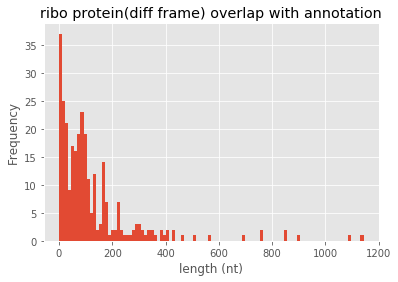

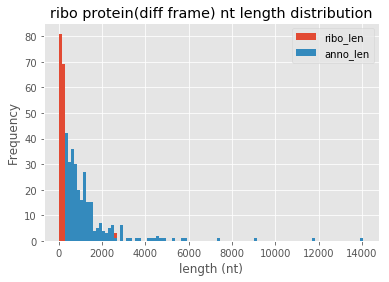

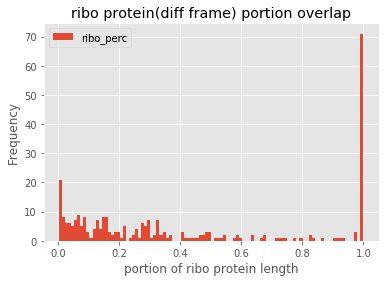

In [12]:
uni_diff_ribo_anno_inter_df['ribo_len']=uni_diff_ribo_anno_inter_df['ribo_e']-uni_diff_ribo_anno_inter_df['ribo_s']
uni_diff_ribo_anno_inter_df['anno_len']=uni_diff_ribo_anno_inter_df['anno_e']-uni_diff_ribo_anno_inter_df['anno_s']
uni_diff_ribo_anno_inter_df['ribo_perc']=uni_diff_ribo_anno_inter_df['length']/uni_diff_ribo_anno_inter_df['ribo_len']
ax = uni_diff_ribo_anno_inter_df['length'].plot(kind='hist',bins=100)
_ = ax.set_title('ribo protein(diff frame) overlap with annotation')
_ = ax.set_xlabel('length (nt)')
ax = uni_diff_ribo_anno_inter_df[['ribo_len','anno_len']].plot(kind='hist',bins=100)
_ = ax.set_title('ribo protein(diff frame) nt length distribution')
_ = ax.set_xlabel('length (nt)')
ax = uni_diff_ribo_anno_inter_df[['ribo_perc']].plot(kind='hist',bins=100)
_ = ax.set_title('ribo protein(diff frame) portion overlap')
_ = ax.set_xlabel('portion of ribo protein length')

### Analyze transcripts with duplicated proteins, it seems like there are many transcripts have multiple proteins, except the ones same with annotation, those proteins in different frames are much shorter than the annotation and are usually overlapped with annotation. **

In [13]:
def dup_df2dic(dup_df):
    '''transfer duplicated proteins into dictionaries
    the first item in the values is annotation region, the
    rest are riboseq regions'''
    dup_norna_dic = {} # annotation doesn't have protein
    dup_dic = {}  # annotation has protein
    for index,row in dup_df.iterrows():
        rnaid = row['transcript_id']
        if np.isnan(row['annotated_start']):
            if rnaid in dup_norna_dic:
                dup_norna_dic[rnaid].append([row['start_pos'],row['stop_pos']])
            else:
                dup_norna_dic[rnaid] = [[row['start_pos'],row['stop_pos']]]
        else:
            if rnaid in dup_dic:
                dup_dic[rnaid].append([row['start_pos'],row['stop_pos']])
            else:
                dup_dic[rnaid]=[[int(row['annotated_start']),int(row['annotated_stop'])]
                               ,[row['start_pos'],row['stop_pos']]]
    # sort based on start position
    for k, v in dup_norna_dic.iteritems():
        dup_norna_dic[k] = sorted(v,key=lambda x:x[0])
    for k, v in dup_dic.iteritems():
        dup_dic[k] = [v[0]] + sorted(v[1:],key=lambda x:x[0])
    return dup_dic,dup_norna_dic

def check_overlap_nornas(dic):
    '''check how many rnas with duplicate novel proteins overlapped
    dic: {rnaid:[[s1,e1],[s2,e2]]}''' 
    dup_overlap_nornas = []
    for k,v in dic.iteritems():
        for i in range(len(v)-1):
            if range(max([v[i][0],v[i+1][0]]),min([v[i][1],v[i+1][1]])) != []:
                dup_overlap_nornas.append(k)
                break
    return dup_overlap_nornas

def check_overlap_rnas(dic):
    '''check how many rnas with duplicate proteins overlapped
    dic: {rnaid:[[anno_s,anno_e],[s1,e1],[s2,e2]]}''' 
    dup_overlap_rnas = []
    for k,v in dic.iteritems():
        for i in range(1,len(v)-1):
            if range(max([v[i][0],v[i+1][0]]),min([v[i][1],v[i+1][1]])) != []:
                dup_overlap_rnas.append(k)
                break
    return dup_overlap_rnas

In [14]:
dup_dic,dup_norna_dic = dup_df2dic(dup_df)
print 'In duplicated proteins, there are',len(dup_norna_dic),'rnas do not have',\
        'proteins in annotation but have proteins in riboseq'
dup_nornas = list(set(dup_norna_dic.keys())-set(ncrna_crnas))
print 'After filterring out non coding rnas whose isoforms encode proteins, there are',\
            len(dup_nornas),'left to be further analyzed'

In duplicated proteins, there are 311 rnas do not have proteins in annotation but have proteins in riboseq
After filterring out non coding rnas whose isoforms encode proteins, there are 310 left to be further analyzed


In [15]:
dup_overlap_nornas = check_overlap_nornas(dup_norna_dic)
print 'There are',len(dup_overlap_nornas),'rnas do not have proteins in annotation',\
            ' and have duplicated proteins in riboseq overlapped with each othter'
dup_noverlap_nornas = list(set(dup_norna_dic.keys())-set(dup_overlap_nornas))
dup_overlap_rnas = check_overlap_rnas(dup_dic)
print 'There are',len(dup_overlap_rnas),'rnas have proteins in both annotaion and riboseq',\
        'and they overlapped with each other'

There are 54 rnas do not have proteins in annotation  and have duplicated proteins in riboseq overlapped with each othter
There are 733 rnas have proteins in both annotaion and riboseq and they overlapped with each other


* First analyze the rnas that have one ribo protein same with annotation

In [16]:
def get_stats4_dup_same_rnas(dup_same_rnas_dic):
    dup_utr5_rnas = []
    dup_utr3_rnas = []
    for k,v in dup_same_rnas_dic.iteritems():
        for i in v[1:]:
            if i[1] <= v[0][0]:
                i.append('utr5')
                dup_utr5_rnas.append(k)
            elif i[0]>=v[0][1]:
                i.append('utr3')
                dup_utr3_rnas.append(k)
            else:
                percent = (min(i[1],v[0][1])-max(i[0],v[0][0]))/float((i[1]-i[0]))
                i.append('overlap '+str(percent))
    dup_utr5_rnas = set(dup_utr5_rnas)
    dup_utr3_rnas = set(dup_utr3_rnas)
    dup_utr5_3_rnas = dup_utr5_rnas.intersection(dup_utr3_rnas)
    dup_same_rnas_overlap_rnas = set(dup_same_rnas_dic.keys())-dup_utr5_rnas-dup_utr3_rnas
    overlap_pct = {}
    for rna in dup_same_rnas_overlap_rnas:
        v = dup_same_rnas_dic[rna]
        for i in v[1:]:
            if v[0] != i[:2]:
                overlap_pct[rna]=float(i[2].split()[1])
    dup_utr5_only_rnas = set(dup_utr5_rnas) - set(dup_utr5_3_rnas)
    dup_utr3_only_rnas = set(dup_utr3_rnas) - set(dup_utr5_3_rnas)
    print 'there are',len(dup_utr5_3_rnas),'rnas have both 5 and 3 UTR and proteins'
    print 'there are',len(dup_utr5_rnas)-len(dup_utr5_3_rnas),'rnas that have ribo 5UTR and proteins'
    print 'there are',len(dup_utr3_rnas)-len(dup_utr5_3_rnas),'rnas that have ribo 3UTR and proteins'
    print 'there are',len(dup_same_rnas_overlap_rnas),'rnas that have prs overlap with annotation'
    return overlap_pct,list(dup_utr5_3_rnas),list(dup_utr5_only_rnas),list(dup_utr3_only_rnas),list(dup_same_rnas_overlap_rnas)

In [17]:
# get rnas that have one ribo protein same with annotation
dup_same_rnas = []
for k,v in dup_dic.iteritems():
    for i in v[1:]:
        if i == v[0]:
            dup_same_rnas.append(k)
            break
dup_same_rnas_dic = copy.deepcopy({k:dup_dic[k] for k in dup_same_rnas})
dup_same_rnas_overlap_pct,dup_same_rnas_utr53,dup_same_rnas_utr5,dup_same_rnas_utr3,dup_same_rnas_overlap = get_stats4_dup_same_rnas(dup_same_rnas_dic)

there are 84 rnas have both 5 and 3 UTR and proteins
there are 1151 rnas that have ribo 5UTR and proteins
there are 580 rnas that have ribo 3UTR and proteins
there are 367 rnas that have prs overlap with annotation


In [18]:
# get rnas that have ribo proteins different with annotation
dup_diff_rnas_dic = copy.deepcopy({k:dup_dic[k] for k in dup_dic if k not in dup_same_rnas})
dup_diff_rnas_overlap_pct,dup_diff_rnas_utr53,dup_diff_rnas_utr5,dup_diff_rnas_utr3,dup_diff_rnas_overlap = get_stats4_dup_same_rnas(dup_diff_rnas_dic)

there are 42 rnas have both 5 and 3 UTR and proteins
there are 628 rnas that have ribo 5UTR and proteins
there are 437 rnas that have ribo 3UTR and proteins
there are 391 rnas that have prs overlap with annotation


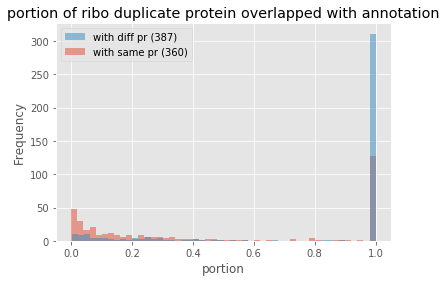

In [19]:
df = pd.DataFrame.from_dict(dup_same_rnas_overlap_pct,orient='index')
ax = df[0].plot(kind='hist',bins=50,alpha=0.5,label='with same pr (360)')
df = pd.DataFrame.from_dict(dup_diff_rnas_overlap_pct,orient='index')
ax = df[0].plot(kind='hist',bins=50,alpha=0.5,label='with diff pr (387)')
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
_ = ax.set_title('portion of ribo duplicate protein overlapped with annotation')
_ = ax.set_xlabel('portion')

In [20]:
def add_dup_norna_type(rna_dic,rnas,feature,pos_dic):
    for rna in rnas:
        pos = pos_dic[rna]
        for p in pos:
            key = '_'.join([rna,str(p[0]),str(p[1])])
            rna_dic[key] = [feature,feature]
    return rna_dic

def add_dup_same_rna_type(rna_dic,rnas,feature,pos_dic):
    for rna in rnas:
        pos = pos_dic[rna]
        for p in pos[1:]:
            key = '_'.join([rna,str(p[0]),str(p[1])])
            if 'overlap' in p[2]:
                if p[2] == 'overlap 1.0':
                    rna_type_dic[key] = [feature, 'same']
                else:
                    rna_type_dic[key] = [feature, 'overlap']
            else:
                rna_type_dic[key] = [feature, p[2]]
    return rna_dic

def add_uni_rna_type(rna_dic,rnas,feature):
    for rna in rnas:
        if rna in rna_dic:
            assert False,rna+' already in dictionary'
        else:
            rna_dic[rna] = feature
    return rna_dic
        
rna_type_dic = {}
rna_type_dic = add_uni_rna_type(rna_type_dic,uni_rna_types[0],'uni_same')
rna_type_dic = add_uni_rna_type(rna_type_dic,uni_rna_types[1],'uni_new')
rna_type_dic = add_uni_rna_type(rna_type_dic,extend_rnas,'uni_extend')
rna_type_dic = add_uni_rna_type(rna_type_dic,shrink_rnas,'uni_shrink')
rna_type_dic = add_uni_rna_type(rna_type_dic,uni_sf_utr5_rnas,'uni_sf_utr5')
rna_type_dic = add_uni_rna_type(rna_type_dic,uni_sf_utr3_rnas,'uni_sf_utr3')
rna_type_dic = add_uni_rna_type(rna_type_dic,uni_diff_ribo_anno_inter_anno_rnas,'uni_diff_overlap')
rna_type_dic = add_uni_rna_type(rna_type_dic,uni_diff_utr5_rnas,'uni_diff_utr5')
rna_type_dic = add_uni_rna_type(rna_type_dic,uni_diff_utr3_rnas,'uni_diff_utr3')

rna_type_dic = add_dup_norna_type(rna_type_dic,dup_overlap_nornas,'dup_overlap_nornas',dup_norna_dic) # overlap with it self
rna_type_dic = add_dup_norna_type(rna_type_dic,dup_noverlap_nornas,'dup_noverlap_nornas',dup_norna_dic)
rna_type_dic = add_dup_same_rna_type(rna_type_dic,dup_same_rnas_overlap,'dup_same_overlap',dup_same_rnas_dic)
rna_type_dic = add_dup_same_rna_type(rna_type_dic,dup_same_rnas_utr53,'dup_same_utr53',dup_same_rnas_dic)
rna_type_dic = add_dup_same_rna_type(rna_type_dic,dup_same_rnas_utr5,'dup_same_utr5',dup_same_rnas_dic)
rna_type_dic = add_dup_same_rna_type(rna_type_dic,dup_same_rnas_utr3,'dup_same_utr3',dup_same_rnas_dic)
rna_type_dic = add_dup_same_rna_type(rna_type_dic,dup_diff_rnas_overlap,'dup_diff_overlap',dup_diff_rnas_dic)
rna_type_dic = add_dup_same_rna_type(rna_type_dic,dup_diff_rnas_utr53,'dup_diff_utr53',dup_diff_rnas_dic)
rna_type_dic = add_dup_same_rna_type(rna_type_dic,dup_diff_rnas_utr5,'dup_diff_utr5',dup_diff_rnas_dic)
rna_type_dic = add_dup_same_rna_type(rna_type_dic,dup_diff_rnas_utr3,'dup_diff_utr3',dup_diff_rnas_dic)

|                 |          Summary                 |                             |
|-----------------|----------------------------------|-----------------------------|
| Unique (24733)  | same pr (13528)                  |                             |
|                 | new pr (1603)                    | filter coding isoform(1367) |
|                 | diff same frame (8708)           | Extend (480)                |
|                 |                                  | Shrink (8228)               |
|                 | diff diff frame (894)            | Overlap with anno (272)     |
|                 |                                  | UTR5 (446)                  |
|                 |                                  | UTR3 (176)                  |
| Duplicate(3974) | new pr (360)                     | Filter coding isoform (323) |
|                 |                                  | Overlap(56)                 |
|                 |                                  | Nonoverlap (304)            |
|                 | One is same with  anno pr (2151) | Overlap (360)               |
|                 |                                  | UTR5_3 (84)                 |
|                 |                                  | UTR5 (1135)                 |
|                 |                                  | UTR3 (572)                  |
|                 | Diff pr (1463)                   | Overlap(387)                |
|                 |                                  | UTR5_3 (41)                 |
|                 |                                  | UTR5 (609)                  |
|                 |                                  | UTR3 (426)                  |

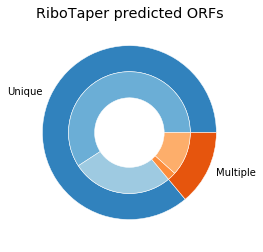

In [21]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

size = 0.3
# vals = np.array([[16982, 648],[7727, 3343]])
vals = np.array([[16982, 7727],[648, 3343]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4)
inner_colors = cmap(np.array([1, 2, 5,6]))

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),labels=['Unique', 'Multiple'])

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='RiboTaper predicted ORFs')
plt.savefig('/data/shangzhong/ribotaper.svg')

In [22]:
fn = '/data/shangzhong/Proteogenomics/event_results/novel_res.txt'
df = pd.read_csv(fn,sep='\t',header=0)

In [23]:
df['pep'] = df['Peptide'].map(lambda x: ''.join([p for p in x if p.isalpha()])[:-1])

In [24]:
df['pep'].unique().size

9808

#### Analyze known pepties statistics

In [25]:
path = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie'
dft_pr_fn = path + '/03_pasa_stringtie_pr.fa'
# unique protein sequences
dft_pep_pr_dic = {}
for record in SeqIO.parse(dft_pr_fn, 'fasta'):
    seq = str(record.seq)
    if seq in dft_pep_pr_dic:
        dft_pep_pr_dic[seq].append(record.id)
    else:
        dft_pep_pr_dic[seq] = [record.id]
dft_prs = [v[0] for v in dft_pep_pr_dic.values()]

In [26]:
ribotaper_pro_path = '/data/s3cha/CHO_ENOSI_JOB/taper'
known_pep_pos_fn = ribotaper_pro_path + '/known_pos.txt'
novel_pep_pos_fn = ribotaper_pro_path + '/all_event_locations.txt'
ribo_pep_pos_fn = ribotaper_pro_path + '/ribo_pep_pos.txt'
ribo_pep_pos2knowndb_fn = ribotaper_pro_path + '/ribo_pep_pos_in_knownDB.txt'

In [27]:
def get_gene_rna(ham_gff):
    '''add geneid, rnaid, rna confident score to gff dataframe 
    return gff_df and rna_gene_dic in format of {rna id:gene id}'''
    gff_df = pd.read_csv(ham_gff,sep='\t',header=None,comment='#')
    gff_df = gff_df[gff_df[2].values=='mRNA']
    gff_df['rnaid'] = gff_df[8].map(lambda x: re.search('(?<=ID=).+?(?=;)',x).group(0))
    gff_df['geneid'] = gff_df[8].map(lambda x: re.search('(?<=gene_id=).+?(?=;)',x).group(0))
    rna_gene_dic = gff_df.set_index('rnaid')['geneid'].to_dict()
    gff_df['rna_cs'] = gff_df[8].map(lambda x: re.search('(?<=cs=).+?(?=$|;)',x).group(0))
    return gff_df,rna_gene_dic

gff_df,rna_gene_dic = get_gene_rna(ham_gff)

In [28]:
def add_geneid_pepnum(pep_pos_fn,rna_gene_dic):
    ''' add geneid, and number of genes each peptide map to
    pep_pos_fn: 4 columns [rna, pep, pos, spec_num]. 
    rna_gene_dic: {rnaid, geneid}
    '''
    # analyze known peptides
    pep_pos_df = pd.read_csv(pep_pos_fn,sep='\t',header=0,names=['rna','pep','pos','spec_num'])
    pep_pos_df['geneid'] = pep_pos_df['rna'].map(lambda x:rna_gene_dic[x])
    # get {pep: number of genes mapped to}
    pep_gene_dic = pep_pos_df[['pep','geneid']].drop_duplicates().groupby('pep').count().to_dict()['geneid']
    pep_pos_df['pep_num_gene'] = pep_pos_df['pep'].map(lambda x: pep_gene_dic[x])
    return pep_pos_df

known_pep_pos_df = add_geneid_pepnum(known_pep_pos_fn,rna_gene_dic)

In [29]:
print 'there are',known_pep_pos_df.query('pep_num_gene == 1')['pep'].unique().shape[0],'peptides map uniquely to known db'

there are 208904 peptides map uniquely to known db


In [30]:
def get_verified_proteins(known_pep_pos_df):
    '''get proteins verified by peptides
    known_pep_pos_df: dataframe with columns, ['rna', 'pep', 'pos', 'spec_num', 'geneid', 'pep_num_gene']
    '''
    rna_pepnum_dic = {k:list(v) for k,v in known_pep_pos_df.groupby('rna')['pep_num_gene']}
    # get verified proteins
    verified_prs = []
    for k,v in rna_pepnum_dic.iteritems():
        if 1 in v and len(v)>1:
            verified_prs.append(k)
    return verified_prs

verified_prs = get_verified_proteins(known_pep_pos_df)
print 'there are',len(verified_prs),'proteins have at least two peptides with at least one peptides map uniquely'

there are 41409 proteins have at least two peptides with at least one peptides map uniquely


In [31]:
# analyze known peptides
print 'known_pep_pos_df line:',known_pep_pos_df.shape[0]
print 'after remove duplicate lines',known_pep_pos_df[['rna','pep']].drop_duplicates().shape[0]
print 'if the two numbers above are the same, it means there is no peptide map to multi locations in a rna \n'

print 'draft annotation protein confidence scores', gff_df['rna_cs'].value_counts().to_dict()
print 'verified proteins with different confidence scores', gff_df.query('rnaid in @verified_prs')['rna_cs'].value_counts().to_dict(),'\n'

known_pep_pos_df line: 1029274
after remove duplicate lines 1029274
if the two numbers above are the same, it means there is no peptide map to multi locations in a rna 

draft annotation protein confidence scores {'1': 49084, '3': 2607, '2': 10260, '5': 16070, '4': 4129}
verified proteins with different confidence scores {'1': 34626, '3': 1313, '2': 4579, '4': 891} 



#### Anazlye MS to Ribo protein sequence results
1. Get peptide position relative to proteins in protein databases for ribo_new peptides and known peptides
2. Get transcripts that have peptides support extend and shrink portion

In [32]:
def read_ribo_pep_pos_df(fn):
    '''
    df: ['id', 'pep', 'pos', 'spec_num', 'nt_pos', 'rnaid', 'geneid']
    dic: {ribo_pr_fa_header: [list of positions of peptides]}
    pep_dic: {ribo_pr_fa_header:[list of peptides]}
    '''
    df = pd.read_csv(fn,sep='\t',header=0,names=['id','pep','pos','spec_num'])
    df['nt_pos'] = df['pos']*3
    df['rnaid']  = df['id'].map(lambda x: '_'.join(x.split('_')[0].split('-')))
    df['start']  = df['id'].map(lambda x: int(x.split(':')[0].split('_')[1])-1)
    df['end']  = df['id'].map(lambda x: int(x.split(':')[0].split('_')[2])+2)
    df['pos2rna'] = df['start'] + df['nt_pos']
    df['geneid'] = df['id'].map(lambda x: x.split(':')[1])
    df['rnaid_pos'] = df.apply(lambda x: '_'.join([x['rnaid'],str(x['start']),str(x['end'])]),axis=1)
    pep_gene_dic = df[['pep','geneid']].drop_duplicates().groupby('pep').count().to_dict()['geneid']
    df['pep_num_gene'] = df['pep'].map(lambda x: pep_gene_dic[x])
#     dic = {k:list(v) for k,v in df.groupby('id')['pos']}
#     pep_dic = {k:list(v) for k,v in df.groupby('id')['pep']}
    return df

# known_pep_pos_dic = {k:list(v) for k,v in known_pep_pos_df.groupby('rna')['pos']}
# known_pep_dic   = {k:list(v) for k,v in known_pep_pos_df.groupby('rna')['pep']}
ribo_pep_pos_df = read_ribo_pep_pos_df(ribo_pep_pos_fn)
ribo_pep_pos2knowndb_df = pd.read_csv(ribo_pep_pos2knowndb_fn,sep='\t',header=0,names=['id','pep','pos','spec_num'])
ribo_pep2known = ribo_pep_pos2knowndb_df['pep'].unique().tolist()
recmb = ['lightchain_mRNA','heavychain_mRNA','NeoRKanR_mRNA']
ribo_pep_pos_df = ribo_pep_pos_df.query('(pep not in @ribo_pep2known) & (rnaid not in @recmb)')
ribo_pep_pos_df = ribo_pep_pos_df.reset_index(drop=True)
ribo_pep_pos_df['anno_s'] = ribo_pep_pos_df['rnaid'].map(lambda x:cds_s_e_dic[x][0] if x in cds_s_e_dic else '')
ribo_pep_pos_df['anno_e'] = ribo_pep_pos_df['rnaid'].map(lambda x:cds_s_e_dic[x][1] if x in cds_s_e_dic else '')

In [33]:
uni_ribo_pep_pos_df = ribo_pep_pos_df[ribo_pep_pos_df['rnaid'].isin(rna_type_dic.keys())]
uni_ribo_pep_pos_df = uni_ribo_pep_pos_df.reset_index(drop=True)
uni_ribo_pep_pos_df['type'] = uni_ribo_pep_pos_df['rnaid'].map(lambda x: rna_type_dic[x])
dup_ribo_pep_pos_df = ribo_pep_pos_df[ribo_pep_pos_df['rnaid_pos'].isin(rna_type_dic.keys())]
dup_ribo_pep_pos_df = dup_ribo_pep_pos_df.reset_index(drop=True)
dup_ribo_pep_pos_df['type'] = dup_ribo_pep_pos_df['rnaid_pos'].map(lambda x: rna_type_dic[x][0])
dup_ribo_pep_pos_df['type1'] = dup_ribo_pep_pos_df['rnaid_pos'].map(lambda x: rna_type_dic[x][1])

In [34]:
# 1. check how many peptides are newly identified using riboseq
novel_pep_pos_df = pd.read_csv(novel_pep_pos_fn,sep='\t',header=None,comment='#')
novel_peps = novel_pep_pos_df[2].unique().tolist()
ribo_peps = ribo_pep_pos_df['pep'].unique().tolist()
print 'filter known pep, there are',len(ribo_peps),'peptides uniquely identified using riboseq database'

filter known pep, there are 2617 peptides uniquely identified using riboseq database


In [35]:
# ribo_pep_pos_orign_dic = {} # change key from asmbl-region:..:..: to asmbl_region
# for k,v in ribo_pep_pos_dic.iteritems():
#     k = k.split(':')[0]
#     ribo_pep_pos_orign_dic[k] = v

#### For unique proteins from ribotaper
##### 1. check if there are peptides support uni no rnas

In [36]:
def uni_get_pep_support_ribo_rnas(df,novel=novel_peps):
    dic = {k:list(v) for k,v in df.groupby('rnaid')['pep_num_gene']}
    dic = {k:v for k,v in dic.iteritems() if 1 in v}
    df = df.query('pep not in @novel_peps')
    fil_dic = {k:list(v) for k,v in df.groupby('rnaid')['pep_num_gene']}
    fil_dic = {k:v for k,v in dic.iteritems() if 1 in v}
    print 'after filter there are',len(fil_dic),'rnas'
    return dic

In [37]:
uni_new_df = uni_ribo_pep_pos_df.query('type == "uni_new"')
uni_new_df = uni_new_df.reset_index(drop=True)
uni_new_pep_rnas_dic = uni_get_pep_support_ribo_rnas(uni_new_df)
print 'there are',len(uni_new_pep_rnas_dic), 'ribo uni new rnas have peptides support'

after filter there are 168 rnas
there are 168 ribo uni new rnas have peptides support


##### 2. check if there are peptides support extend protion in riboseq

In [38]:
def get_extend(row):
    '''this function gets peptides that locates in the extended region compared to annotation'''
    if row['start'] <= row['pos2rna'] < row['anno_s']:
        return 'yes'
    else:
        return 'no'

# extend
uni_extend_df = uni_ribo_pep_pos_df.query('type=="uni_extend"')
uni_extend_df = uni_extend_df.reset_index(drop=True)
extend_pep_rnas_dic = uni_get_pep_support_ribo_rnas(uni_extend_df)
uni_extend_df['extend_region'] = uni_extend_df.apply(lambda x:get_extend(x),axis=1)
print 'there are',len(extend_pep_rnas_dic),'extend rnas have peptide support'

after filter there are 8 rnas
there are 8 extend rnas have peptide support


##### 3. check if there are peptides support extend protion in riboseq

In [39]:
def get_shrink_pep(row,known_pep_pos_dic):
    '''this function gets peptides that locates in the shrink region compared to annotation'''
    try:
        pep = known_pep_pos_dic[row['transcript_id']]
        pep = [p for p in pep if row['annotated_start']<=p<row['start_pos']]
    except:
        pep = []
    return ','.join([str(p) for p in pep])

known_pep_pos_dic = {k:list(v) for k,v in known_pep_pos_df.groupby('rna')['pos']}
# shrink proteins
uni_shrink_df = uni_diff_sf_rna_df.query('dist < 0')
uni_shrink_df = uni_shrink_df.reset_index(drop=True)
uni_shrink_df['pep_loc'] = uni_shrink_df.apply(lambda x:get_shrink_pep(x,known_pep_pos_dic),axis=1)
pep_sup_uni_shrink_df = uni_shrink_df.query('pep_loc != ""')
print 'Among',uni_shrink_df.shape[0],'unique shrink proteins',pep_sup_uni_shrink_df.shape[0],\
    'have peptides support'

Among 8280 unique shrink proteins 4680 have peptides support


##### 4. check if uni utr5 and utr3 have peptides

In [40]:
uni_utr5_df = uni_ribo_pep_pos_df.query('type == "uni_sf_utr5"')
uni_utr5_pep_rnas_dic = uni_get_pep_support_ribo_rnas(uni_utr5_df)
print 'there are',len(uni_utr5_pep_rnas_dic),'ribo uni same frame utr5 rnas have peptide support'
uni_utr3_df = uni_ribo_pep_pos_df.query('type == "uni_sf_ut35"')
uni_utr3_pep_rnas_dic = uni_get_pep_support_ribo_rnas(uni_utr3_df)
print 'there are',len(uni_utr3_pep_rnas_dic),'ribo uni same frame utr3 rnas have peptide support'

after filter there are 12 rnas
there are 12 ribo uni same frame utr5 rnas have peptide support
after filter there are 0 rnas
there are 0 ribo uni same frame utr3 rnas have peptide support


##### 5. check if uni diff overlap, utr5, utr3 have peptide support

In [41]:
uni_diff_overlap_df = uni_ribo_pep_pos_df.query('type == "uni_diff_overlap"')
uni_diff_overlap_pep_rnas_dic = uni_get_pep_support_ribo_rnas(uni_diff_overlap_df)
print 'there are',len(uni_diff_overlap_pep_rnas_dic),'ribo uni diff frame overlap with anno rnas have peptide support'
uni_diff_utr5_df = uni_ribo_pep_pos_df.query('type == "uni_diff_utr5"')
uni_diff_utr5_pep_rnas_dic = uni_get_pep_support_ribo_rnas(uni_diff_utr5_df)
print 'there are',len(uni_diff_utr5_pep_rnas_dic),'ribo uni diff frame utr5 rnas have peptide support'
uni_diff_utr3_df = uni_ribo_pep_pos_df.query('type == "uni_diff_utr3"')
uni_diff_utr3_pep_rnas_dic = uni_get_pep_support_ribo_rnas(uni_diff_utr3_df)
print 'there are',len(uni_diff_utr3_pep_rnas_dic),'ribo uni diff frame utr3 rnas have peptide support'

after filter there are 9 rnas
there are 9 ribo uni diff frame overlap with anno rnas have peptide support
after filter there are 31 rnas
there are 31 ribo uni diff frame utr5 rnas have peptide support
after filter there are 24 rnas
there are 24 ribo uni diff frame utr3 rnas have peptide support


##### 6. check if dup new pr have peptide support

In [42]:
dup_overlap_nornas_df = dup_ribo_pep_pos_df.query('type == "dup_overlap_nornas"')
dup_overlap_nornas_pep_rnas_dic = uni_get_pep_support_ribo_rnas(dup_overlap_nornas_df)
print 'there are',len(dup_overlap_nornas_pep_rnas_dic),'ribo dup overlap nornas have peptide support'
dup_noverlap_nornas_df = dup_ribo_pep_pos_df.query('type == "dup_noverlap_nornas"')
dup_noverlap_nornas_pep_rnas_dic = uni_get_pep_support_ribo_rnas(dup_noverlap_nornas_df)
print 'there are',len(dup_noverlap_nornas_pep_rnas_dic),'ribo dup overlap nornas have peptide support'

after filter there are 22 rnas
there are 22 ribo dup overlap nornas have peptide support
after filter there are 28 rnas
there are 28 ribo dup overlap nornas have peptide support


##### 7. check if dup with one the same with annotation have peptide

In [43]:
def dup_same_get_pep_support_ribo_rnas(df):
    same = df.query('type1 == "same"')
    dic_same = {k:list(v) for k,v in same.groupby('rnaid')['pep_num_gene']}
    dic_same = {k:v for k,v in dic_same.iteritems() if 1 in v}
    other = df.query('type1 != "same"')
    dic_other = {k:list(v) for k,v in other.groupby('rnaid')['pep_num_gene']}
    dic_other = {k:v for k,v in dic_other.iteritems() if 1 in v}
    return dic_same,dic_other

dup_same_rnas_overlap_df = dup_ribo_pep_pos_df.query('type == "dup_same_overlap"')
dup_same_rnas_overlap_dic,dup_same_rnas_overlap_pep_dic = dup_same_get_pep_support_ribo_rnas(dup_same_rnas_overlap_df)
print 'there are',len(dup_same_rnas_overlap_pep_dic),'dup same rnas overlap with peptide support'
dup_same_rnas_utr53_df = dup_ribo_pep_pos_df.query('type == "dup_same_utr53"')
dup_same_rnas_utr53_dic,dup_same_rnas_utr53_pep_dic = dup_same_get_pep_support_ribo_rnas(dup_same_rnas_utr53_df)
print 'there are',len(dup_same_rnas_utr53_pep_dic),'dup same rnas utr5 and utr3 with peptide support'
dup_same_rnas_utr5_df = dup_ribo_pep_pos_df.query('type == "dup_same_utr5"')
dup_same_rnas_utr5_dic,dup_same_rnas_utr5_pep_dic = dup_same_get_pep_support_ribo_rnas(dup_same_rnas_utr5_df)
print 'there are',len(dup_same_rnas_utr5_pep_dic),'dup same rnas utr5 with peptide support'
dup_same_rnas_utr3_df = dup_ribo_pep_pos_df.query('type == "dup_same_utr3"')
dup_same_rnas_utr3_dic,dup_same_rnas_utr3_pep_dic = dup_same_get_pep_support_ribo_rnas(dup_same_rnas_utr3_df)
print 'there are',len(dup_same_rnas_utr3_pep_dic),'dup same rnas utr3 with peptide support'

there are 6 dup same rnas overlap with peptide support
there are 7 dup same rnas utr5 and utr3 with peptide support
there are 40 dup same rnas utr5 with peptide support
there are 44 dup same rnas utr3 with peptide support


##### 8. check if dup with diff rnas have peptide support

In [44]:
dup_diff_rnas_overlap_df = dup_ribo_pep_pos_df.query('type == "dup_diff_overlap"')
dup_diff_rnas_overlap_pep_dic = uni_get_pep_support_ribo_rnas(dup_diff_rnas_overlap_df)
print 'there are', len(dup_diff_rnas_overlap_pep_dic), 'dup diff rna overlap have peptides'
dup_diff_rnas_utr53_df = dup_ribo_pep_pos_df.query('type == "dup_diff_utr53"')
dup_diff_rnas_utr53_pep_dic = uni_get_pep_support_ribo_rnas(dup_diff_rnas_utr53_df)
print 'there are', len(dup_diff_rnas_utr53_pep_dic), 'dup diff rna utr53 have peptides'
dup_diff_rnas_utr5_df = dup_ribo_pep_pos_df.query('type == "dup_diff_utr5"')
dup_diff_rnas_utr5_pep_dic = uni_get_pep_support_ribo_rnas(dup_diff_rnas_utr5_df)
print 'there are', len(dup_diff_rnas_utr5_pep_dic), 'dup diff rna utr5 have peptides'
dup_diff_rnas_utr3_df = dup_ribo_pep_pos_df.query('type == "dup_diff_utr3"')
dup_diff_rnas_utr3_pep_dic = uni_get_pep_support_ribo_rnas(dup_diff_rnas_utr3_df)
print 'there are', len(dup_diff_rnas_utr3_pep_dic), 'dup diff rna utr3 have peptides'

after filter there are 5 rnas
there are 5 dup diff rna overlap have peptides
after filter there are 5 rnas
there are 5 dup diff rna utr53 have peptides
after filter there are 25 rnas
there are 25 dup diff rna utr5 have peptides
after filter there are 46 rnas
there are 46 dup diff rna utr3 have peptides
